Members:

Danick Carrier

Joseph Sakkab

Donovan Hiebert

Omkaar Kammath

# Introduction

The business problem is to classify whether a video segment is a commercial or part of the scheduled TV news channel. This is a small, sub-problem of Broadcast Monitoring, which aims to identify content being broadcasted. Unlike TV news segments, commercials tend to have high energy and fast transitions with the aim to grab the consumers attention. These characteristics are quantified in our dataset with complex industry-specific features such as spectral flux, or ZCR. Using this dataset, the learned model can detect if a video segment is a commercial. This model will provide business value by enforcing ad-coverage laws. If a company claims it airs 15% less commercials than a competitor, it would be possible to verify this claim using the machine learning model. Also, this model would enable organizations to generate statistics about the airing time of advertisements. This can help organizations to adjust their advertisement strategy to maximize results. The goal for this project is to use a relatively simple ML model to provide highly accurate classifications through data processing and hyperparameter optimization.

# Data Description

Link to dataset: https://archive.ics.uci.edu/ml/datasets/TV+News+Channel+Commercial+Detection+Dataset

A TV News Channel Commercial dataset is being used for this project. It was found by filtering the datasets on UCI by number of instances, and then looking for a dataset with a moderate amount of features, minimal missing values, and having interesting relevant data. This dataset has 129,685 rows and 4125 columns of data. These features are all numerical values that represent metadata from audio and video sources. Approximately 63% of the dataset are commercials, with a positive class label and there are no NaN values within the dataset. The features or columns of this dataset all contain metadata and metadata summaries of the actual audio and video of the TV stream.

# Imports and Data Loading

In [ ]:
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from math import log10
from sklearn.model_selection import cross_val_score
import shap
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [96]:
# Loading all our data. Same format from different files representing different television channels.
ndtv = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/NDTV.txt")
cnn = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/CNN.txt")
bbc = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/BBC.txt")
cnnibn = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/CNNIBN.txt")
timesnow = load_svmlight_file("D:/data_storage/Projects/ml_commercial_detection/TV_News_Channel_Commercial_Detection_Dataset/TIMESNOW.txt")

In [97]:
# Combining all 5 channels into one
x, y = sc.sparse.vstack([ndtv[0], cnn[0], bbc[0], cnnibn[0], timesnow[0]]), np.concatenate([ndtv[1], cnn[1], bbc[1], cnnibn[1], timesnow[1]])

# Exploratory Data Analysis

The data is complete because `x` and `y` have the same number of rows.

In [98]:
x.shape, y.shape

((129685, 4125), (129685,))

In [99]:
type(x)

scipy.sparse._csr.csr_matrix

In [100]:
# Convert from a sparse matrix to a pandas Dataframe
df = pd.DataFrame.sparse.from_spmatrix(x)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4115,4116,4117,4118,4119,4120,4121,4122,4123,4124
0,29.0,3.821209,1.567568,13.547628,7.242389,0.019883,0.012195,0.067241,0.049107,3406.866211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.524255,0.866498
1,25.0,3.052969,1.641484,22.334589,15.734018,0.023027,0.010731,0.077000,0.045884,3324.158203,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072369,0.534711
2,82.0,1.601274,1.508805,5.860583,3.301121,0.025948,0.006956,0.082317,0.044845,3771.984131,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.552685,0.918764
3,25.0,4.819368,2.879584,41.382828,24.448074,0.014387,0.007596,0.069875,0.046916,3301.686035,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.117911,0.223210
4,29.0,2.768753,1.797319,13.338054,9.980667,0.011506,0.007269,0.100647,0.067401,3266.021484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.529581,0.968130


For the datatypes, all columns are of type Sparse, whereas it should be float. We will fix this in the next section.

In [101]:
df.dtypes

0       Sparse[float64, 0]
1       Sparse[float64, 0]
2       Sparse[float64, 0]
3       Sparse[float64, 0]
4       Sparse[float64, 0]
               ...        
4120    Sparse[float64, 0]
4121    Sparse[float64, 0]
4122    Sparse[float64, 0]
4123    Sparse[float64, 0]
4124    Sparse[float64, 0]
Length: 4125, dtype: object

In [102]:
df.count()

0       129685
1       129685
2       129685
3       129685
4       129685
         ...  
4120    129685
4121    129685
4122    129685
4123    129685
4124    129685
Length: 4125, dtype: int64

In [103]:
df.isnull().sum()

0       0
1       0
2       0
3       0
4       0
       ..
4120    0
4121    0
4122    0
4123    0
4124    0
Length: 4125, dtype: int32

# Data Preprocessing

For preprocessing, the dataset has been split into two dataframes: Feature mean and variance data + Bag of Words data. For the feature mean and variance data, we drop all columns except for the first 17 (mean and variance values). The Bag of Words are Columns 123:4123 from out dataset.

The dataset does not have any null values and is clean so there is no need for the Data Cleaning step. Feature engineering is covered in later sections.

In [104]:
df.drop(df.iloc[:, 17:4123], inplace=True, axis=1)

In [105]:
df.shape

(129685, 19)

All rows are converted from sparse to float.

In [106]:
for i in df.columns:
    df[i] = df[i].values.to_dense().astype(np.float64)

In [107]:
df.dtypes

0       float64
1       float64
2       float64
3       float64
4       float64
5       float64
6       float64
7       float64
8       float64
9       float64
10      float64
11      float64
12      float64
13      float64
14      float64
15      float64
16      float64
4123    float64
4124    float64
dtype: object

Add labels to the dataframe.

In [108]:
df['label'] = y.astype(int).tolist()

In [109]:
df['label'].value_counts()

 1    82231
-1    47454
Name: label, dtype: int64

As seen above, the labels are 1 and -1. Since binary labels are preferred, -1 is converted to 0 below

In [110]:
df.loc[df['label'] == -1, 'label'] = 0
df['label'].value_counts()

1    82231
0    47454
Name: label, dtype: int64

The feature mean and variance data are given names.

In [112]:
#Give the columns names
df.rename(columns={
 0:'shot_length',
 1:'motion_distribution_mean',
 2:'motion_distribution_variance',
 3:'frame_difference_distribution_mean',
 4:'frame_difference_distribution_variance',
 5:'short_time_energy_mean',
 6:'short_time_energy_variance',
 7:'zcr_mean',
 8:'zcr_variance',
 9:'spectral_centroid_mean',
 10:'spectral_centroid_variance',
 11:'spectral_roll_off_mean',
 12:'spectral_roll_off_variance',
 13:'spectral_flux_mean',
 14:'spectral_flux_variance',
 15:'fundamental_frequency_mean',
 16:'fundamental_frequency_variance',
 4123:'edge_change_ratio_mean',
 4124:'edge_change_ratio_variance'
},inplace=True)

In [113]:
df

,shot_length,motion_distribution_mean,motion_distribution_variance,frame_difference_distribution_mean,frame_difference_distribution_variance,short_time_energy_mean,short_time_energy_variance,zcr_mean,zcr_variance,spectral_centroid_mean,spectral_centroid_variance,spectral_roll_off_mean,spectral_roll_off_variance,spectral_flux_mean,spectral_flux_variance,fundamental_frequency_mean,fundamental_frequency_variance,edge_change_ratio_mean,edge_change_ratio_variance,label
0,29.0,3.821209,1.567568,13.547628,7.242389,0.019883,0.012195,0.067241,0.049107,3406.866211,1363.990601,6796.552246,2719.626709,1021.359192,940.742371,102.607803,60.178288,0.524255,0.866498,1
1,25.0,3.052969,1.641484,22.334589,15.734018,0.023027,0.010731,0.077000,0.045884,3324.158203,1452.020752,6610.000488,2885.445312,1199.364380,821.123535,84.687698,46.896881,0.072369,0.534711,1
2,82.0,1.601274,1.508805,5.860583,3.301121,0.025948,0.006956,0.082317,0.044845,3771.984131,855.766479,7488.112305,1697.350586,1544.147461,807.137268,92.694611,41.182648,0.552685,0.918764,1
3,25.0,4.819368,2.879584,41.382828,24.448074,0.014387,0.007596,0.069875,0.046916,3301.686035,1441.997681,6606.000977,2883.914795,599.555176,535.151978,96.595497,61.861046,0.117911,0.223210,1
4,29.0,2.768753,1.797319,13.338054,9.980667,0.011506,0.007269,0.100647,0.067401,3266.021484,1432.114868,6688.794922,2678.393799,446.452423,411.464722,95.036949,48.364391,0.529581,0.968130,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129680,41.0,0.558875,0.247396,2.279039,0.798749,0.023244,0.011390,0.057546,0.035940,3568.417236,1174.369995,7117.683594,2340.709717,1665.174072,1823.522583,87.497238,44.907471,0.190005,0.946195,1
129681,105.0,6.594097,3.418464,17.372873,8.571255,0.020726,0.010193,0.085179,0.051084,3810.282715,760.784424,7528.095215,1502.876709,1426.169800,1907.535034,115.274689,49.007130,0.166974,0.728715,1
129682,100.0,1.299783,0.543502,5.095611,1.527174,0.018389,0.008418,0.104063,0.045564,3817.707275,781.546814,7468.751465,1527.582520,1217.222534,1342.270996,132.880142,51.955788,0.928798,0.437874,1
129683,60.0,0.571542,0.487061,2.218786,2.174240,0.018031,0.007570,0.122708,0.050065,3720.528809,995.352417,7237.083496,1936.077393,896.837219,827.654297,124.423271,51.549557,0.745411,0.260724,1


### Important note on the bag of words

The bag of words does not actually represent the occurrences of certain words, but is an MFCC bag of audio words. This MFCC (Mel-frequency cepstral coefficients) which is a representation of the short-term power spectrum of a sound, relative to each other. 

In the end, the data in those columns is still a measure of what is being said on the broadcast, and it can still be processed as a regular bag of words would be. 

In [114]:
tf= pd.DataFrame(np.array(sc.sparse.csr_matrix.toarray(x))).iloc[:,123:4123]
tf

,123,124,125,126,127,128,129,130,131,132,...,4113,4114,4115,4116,4117,4118,4119,4120,4121,4122
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129681,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The next few steps are for making the tf_idf dataframe.

In [115]:
# Number of documents contains a word(column)
documents = []

for j in range(len(tf.iloc[0, :])):
  count = sum( i > 0 for i in tf.iloc[:, j])
  documents.append(count)
documents

[0,
 6840,
 0,
 11431,
 211,
 37737,
 838,
 691,
 0,
 0,
 22647,
 0,
 0,
 1386,
 0,
 0,
 0,
 493,
 39605,
 4496,
 12528,
 9099,
 0,
 0,
 0,
 21629,
 0,
 0,
 40197,
 0,
 0,
 0,
 33274,
 0,
 0,
 0,
 0,
 0,
 19263,
 0,
 0,
 0,
 7065,
 0,
 31404,
 0,
 0,
 16497,
 0,
 0,
 0,
 0,
 30762,
 0,
 3294,
 0,
 0,
 0,
 13669,
 0,
 0,
 25292,
 14348,
 22041,
 12789,
 0,
 0,
 0,
 17277,
 0,
 13405,
 12244,
 0,
 8809,
 16,
 0,
 0,
 0,
 0,
 438,
 0,
 0,
 5855,
 0,
 11758,
 6195,
 0,
 0,
 841,
 0,
 0,
 4625,
 0,
 0,
 0,
 21490,
 4181,
 55787,
 0,
 1459,
 0,
 0,
 0,
 0,
 0,
 2132,
 3873,
 4536,
 0,
 2590,
 873,
 0,
 19475,
 0,
 0,
 0,
 4676,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 17972,
 0,
 0,
 0,
 0,
 0,
 0,
 5897,
 0,
 14040,
 0,
 0,
 0,
 0,
 43044,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 85335,
 0,
 0,
 0,
 19938,
 0,
 0,
 0,
 0,
 0,
 0,
 2864,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5022,
 0,
 5665,
 0,
 0,
 0,
 0,
 10,
 

In [116]:
#Calculating idf
number_of_documents = sum(tf.iloc[0:, ])
number_of_documents
idf = []
for i in documents:
  value = 0
  if i > 0:
    value = log10(number_of_documents / i)
  else:
    value = 0

  idf.append(value)
idf

[0,
 3.0938515885238367,
 0,
 2.870823465493028,
 4.60462523494626,
 2.3521403184010596,
 4.005663671613676,
 4.089429642869754,
 0,
 0,
 2.5738970101528063,
 0,
 0,
 3.7871444599681645,
 0,
 0,
 0,
 4.236060770966723,
 2.3311576726181085,
 3.276081387682948,
 2.8310259455300844,
 2.969914025213627,
 0,
 0,
 0,
 2.593871249608439,
 0,
 0,
 2.3247140484048354,
 0,
 0,
 0,
 2.4068026779682503,
 0,
 0,
 0,
 0,
 0,
 2.6441837656077958,
 0,
 0,
 0,
 3.0797955240593753,
 0,
 2.4319227215564467,
 0,
 0,
 2.711502715842411,
 0,
 0,
 0,
 0,
 2.4408931224199097,
 0,
 3.411184095410217,
 0,
 0,
 0,
 2.793170946734479,
 0,
 0,
 2.525924517102772,
 2.7721163222400236,
 2.5856763956799136,
 2.822071102877158,
 0,
 0,
 0,
 2.6914393569943837,
 0,
 2.8016408719250543,
 2.840984369318656,
 0,
 2.983981080257737,
 5.724787707588028,
 0,
 0,
 0,
 0,
 4.2874335797398535,
 0,
 0,
 3.1613807908355707,
 0,
 2.8585742343908898,
 3.1368663795318703,
 0,
 0,
 4.00411169444604,
 0,
 0,
 3.263795953168901,
 0,
 0

In [117]:
#Calculating tf_idf
tf_idf = tf.copy()
tf_idf *= idf

We can see that many of those words are not found in any document. In other words, every value in the columns are zero. Therefore we will drop them as they are of no use.

In [118]:
tf_idf=tf_idf.iloc[:,np.nonzero(idf)[0].tolist()]
tf_idf.shape

(129685, 111)

The following are the final datasets. Prefix bag_ for bag of words data and prefix nbag_ (stands for non-bag of words) for mean and variance feature data.

In [119]:
bag_x=tf_idf
bag_y=df['label']
bag_data=tf_idf.join(df['label'])
nbag_x=df.drop(['label'], axis='columns')
nbag_y=df['label']
nbag_data=df

# Visualizations

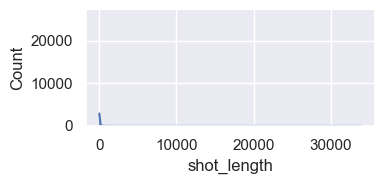

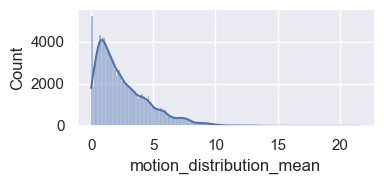

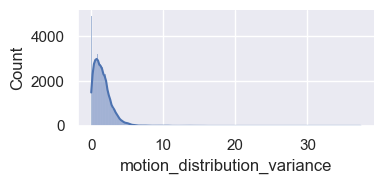

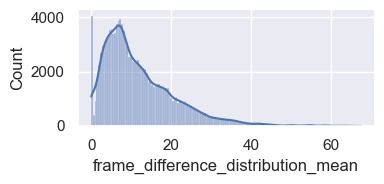

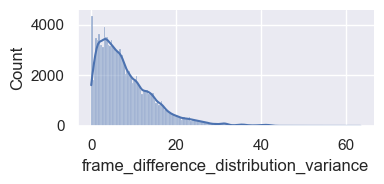

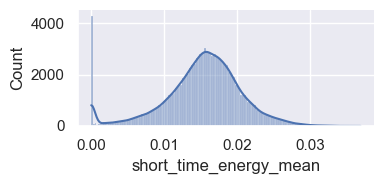

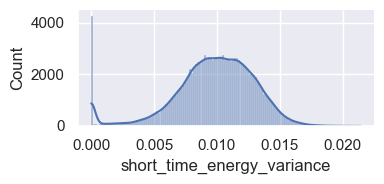

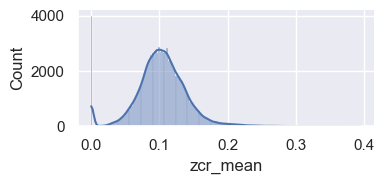

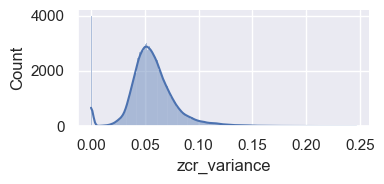

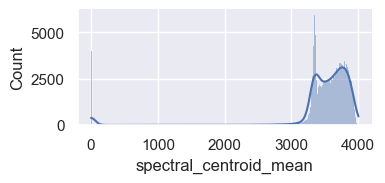

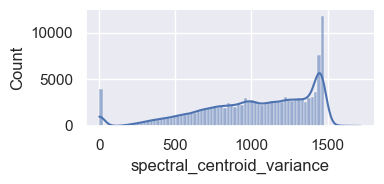

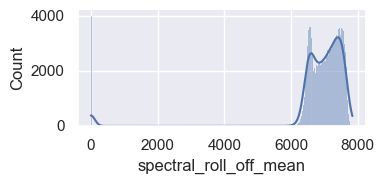

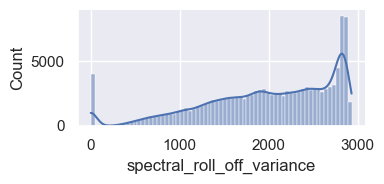

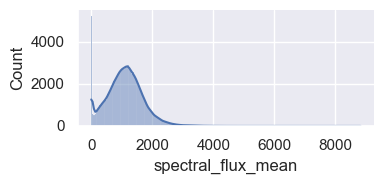

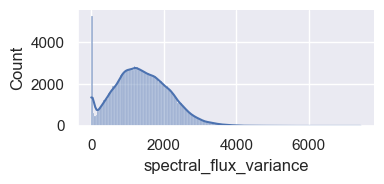

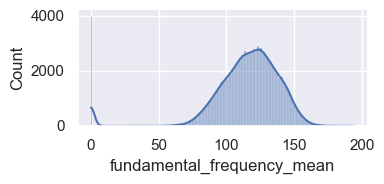

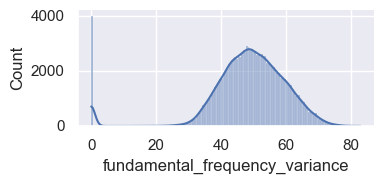

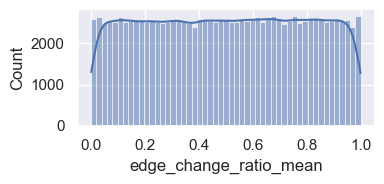

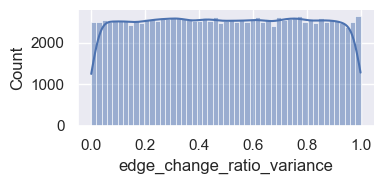

In [ ]:
for col in list(nbag_x.columns):
  sns.displot(nbag_x[col],kde=True,height=2,aspect=2)

# Base model and predictions

The `accuracy` function helps us cross validate the accuracy of models and outputs the classification report for them.

In [126]:
def accuracy(model,x_data,y_data):
  # 10 Fold cross validation
  print("10 Fold CV score: ")
  score=cross_val_score(model,x_data,y_data,cv=10).mean()
  print(score)
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.15, random_state=102, stratify=y_data)
  model.fit(x_train,y_train)
  y_pred=model.predict(x_test)
  # Confusion Matrix
  cm = confusion_matrix(y_test, y_pred)
  # Normalise
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(2,2))
  sns.heatmap(cmn, annot=True, fmt='.2f')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)
  #classification report
  print(pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)))

##### Here is the base model accuracy for feature mean and variance data.

In [122]:
clf = DecisionTreeClassifier()

10 Fold CV score: 
0.8911290205196286


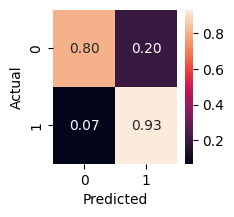

                     0             1  accuracy     macro avg  weighted avg
precision     0.870795      0.889801  0.883411      0.880298      0.882847
recall        0.800084      0.931496  0.883411      0.865790      0.883411
f1-score      0.833943      0.910171  0.883411      0.872057      0.882279
support    7118.000000  12335.000000  0.883411  19453.000000  19453.000000


In [123]:
accuracy(clf,nbag_x,nbag_y)

##### Here is the base model accuracy for the bag of words data.

10 Fold CV score: 
0.907144710237467


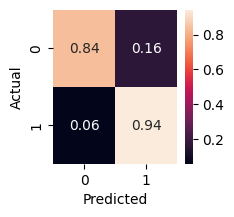

                     0             1  accuracy     macro avg  weighted avg
precision     0.895534      0.910570  0.905413      0.903052      0.905068
recall        0.839421      0.943494  0.905413      0.891458      0.905413
f1-score      0.866570      0.926740  0.905413      0.896655      0.904723
support    7118.000000  12335.000000  0.905413  19453.000000  19453.000000


In [127]:
accuracy(clf,bag_x,bag_y)

# Exploring different ways of improving accuracy

### 1. Undersampling to reduce label imbalance

##### Undersampling for Feature Mean and Variance data

In [128]:
#Splitting the data by label
df_zero = df.loc[df['label'] == 0,:]
df_one = df.loc[df['label'] == 1,:]
df_zero.shape, df_one.shape

((47454, 20), (82231, 20))

10 Fold CV score: 
0.8554600059798207


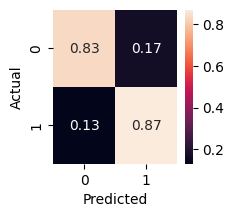

                     0            1  accuracy     macro avg  weighted avg
precision     0.865121     0.839274  0.851724      0.852197      0.852198
recall        0.833404     0.870048  0.851724      0.851726      0.851724
f1-score      0.848966     0.854384  0.851724      0.851675      0.851675
support    7119.000000  7118.000000  0.851724  14237.000000  14237.000000


In [129]:
clf = DecisionTreeClassifier()
data=pd.concat(
  [
    nbag_data.loc[df['label'] == 0,:].sample(n=47454,random_state=42),
    nbag_data.loc[df['label'] == 1,:].sample(n=47454,random_state=42)
  ]
)
accuracy(clf,data.drop(['label'], axis='columns'),data['label'])

##### Undersampling for Bag of Words data

10 Fold CV score: 
0.8757744173144344


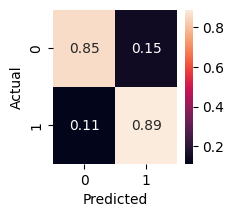

                     0            1  accuracy     macro avg  weighted avg
precision     0.883181     0.859379    0.8709      0.871280      0.871281
recall        0.854895     0.886906    0.8709      0.870901      0.870900
f1-score      0.868808     0.872926    0.8709      0.870867      0.870867
support    7119.000000  7118.000000    0.8709  14237.000000  14237.000000


In [130]:
data=pd.concat(
  [
    bag_data.loc[df['label'] == 0,:].sample(n=47454,random_state=42),
    bag_data.loc[df['label'] == 1,:].sample(n=47454,random_state=42)
  ]
)
accuracy(clf,data.drop(['label'], axis='columns'),data['label'])

#### Conclusion

Undersampling reduces accuracy, therefore we will not include it in our model.

## 2. Oversampling to reduce label imbalancer

##### Data processing for Feature Mean and Variance data

In [131]:
clf = DecisionTreeClassifier()

To avoid having duplicate rows in train and test data, train test split has been performed beforehand, and duplication afterwards.

In [132]:
x_train, x_test, y_train, y_test = train_test_split(nbag_x, nbag_y, test_size=0.15, random_state=102, stratify=nbag_y)
nbag_train=x_train.join(y_train)
nbag_test=x_test.join(y_test)
nbag_train.shape

(110232, 20)

In [133]:
#Let's split the training set by label
df_zero = nbag_train.loc[df['label'] == 0,:]
df_one = nbag_train.loc[df['label'] == 1,:]
df_zero.shape, df_one.shape

((40336, 20), (69896, 20))

In [134]:
nbag_zero_duplicated=nbag_train.loc[df['label'] == 0,:].sample(n=29560,random_state=42)
data=pd.concat(
  [
    nbag_train,
    nbag_zero_duplicated
  ]
)

In [135]:
data.loc[df['label'] == 0,:].shape,data.loc[df['label'] == 1,:].shape

((69896, 20), (69896, 20))

##### Oversampling for Feature Mean and Variance data

In [136]:
clf.fit(data.drop(['label'], axis='columns'), data['label'])
y_pred = clf.predict(nbag_test.drop(['label'], axis='columns'))
accuracy_score(nbag_test['label'], y_pred)

0.886084408574513

##### Oversampling for Bag of Words data

In [137]:
x_train, x_test, y_train, y_test = train_test_split(bag_x, bag_y, test_size=0.15, random_state=102, stratify=bag_y)
bag_train=x_train.join(y_train)
bag_test=x_test.join(y_test)
bag_train.shape

(110232, 112)

In [138]:
bag_zero_duplicated=bag_train.loc[df['label'] == 0,:].sample(n=29560,random_state=42)
data=pd.concat(
  [
    bag_train,
    bag_zero_duplicated
  ]
)

In [139]:
data.loc[df['label'] == 0,:].shape,data.loc[df['label'] == 1,:].shape

((69896, 112), (69896, 112))

In [140]:
clf.fit(data.drop(['label'], axis='columns'), data['label'])
y_pred = clf.predict(bag_test.drop(['label'], axis='columns'))
accuracy_score(bag_test['label'], y_pred)

0.9066981956510564

#### Conclusion
Given the lack of cross-validation, it is hard to make a fair comparison. Since the results performed worse than the base model, this technique should be discarded. This is a bit surprising given the stark imbalance of class labels in the dataset. Over-sampling was expected to work as it is a popular technique to account for class label imbalance.

## 3. Feature scaling to reduce outlier influence

Mean and variance features are to be standardized.

In [141]:
nbag_scaled = nbag_data.drop(['label'], axis='columns').copy()
nbag_scaled.values[:] = StandardScaler().fit_transform(nbag_data.drop(['label'], axis='columns'))

10 Fold CV score: 
0.8904736001699873


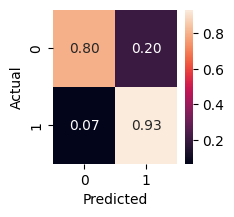

                     0             1  accuracy     macro avg  weighted avg
precision     0.873406      0.889292  0.883977      0.881349      0.883479
recall        0.798679      0.933198  0.883977      0.865939      0.883977
f1-score      0.834373      0.910716  0.883977      0.872545      0.882782
support    7118.000000  12335.000000  0.883977  19453.000000  19453.000000


In [142]:
accuracy(clf,nbag_scaled,nbag_y)

### Conclusion
The accuracy is a little worse, therefore this technique should be discarded as well. The non-better result is expected as Decision tree models don't require scaling to function well.

## 4. Feature selection

This sections deals with eliminating less important features in order to improve accuracy. Less important features have less impact on the performance of the model. The `Importance` column stores how dependent the label is to the particular column's value, thus how 'important' it is to the model.

In [147]:
imp=pd.DataFrame(mutual_info_classif(nbag_x,nbag_y),index=nbag_x.columns)
imp.columns=['Importance']
imp.sort_values(by='Importance',ascending=False)

,Importance
fundamental_frequency_mean,0.221935
spectral_roll_off_variance,0.214769
spectral_centroid_variance,0.210403
spectral_flux_variance,0.208018
spectral_centroid_mean,0.198066
spectral_roll_off_mean,0.184444
fundamental_frequency_variance,0.173472
spectral_flux_mean,0.173053
motion_distribution_variance,0.169162
frame_difference_distribution_variance,0.167232


Features `edge_change_ratio_mean`, `edge_change_ratio_variance` and `shot_length` are of less importance to the model (< 0.1). Therefore, they are discarded.

In [148]:
nbag_selective_features = nbag_x.copy()
nbag_selective_features.drop(list(nbag_selective_features.columns[imp['Importance'] < 0.1]), axis='columns', inplace=True)

10 Fold CV score: 
0.9041529250051932


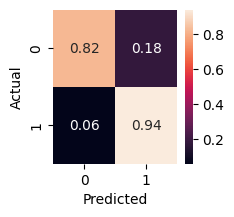

                     0             1  accuracy     macro avg  weighted avg
precision     0.890542      0.902689  0.898576      0.896616      0.898244
recall        0.824108      0.941548  0.898576      0.882828      0.898576
f1-score      0.856038      0.921709  0.898576      0.888874      0.897680
support    7118.000000  12335.000000  0.898576  19453.000000  19453.000000


In [149]:
accuracy(clf,nbag_selective_features,nbag_y)

#### Conclusion
Removing features with <0.1 importance improved model accuracy. Therefore, the respective features should be dropped.

## 5. Combining the bag of words and feature mean and variance data

The two sets of data are combined to test if that improves model accuracy.

In [156]:
#Convert the bag_x colummn names to string for merging purposes
bag_x.columns=bag_x.columns.astype(str)

In [157]:
all_data_x=nbag_selective_features.join(bag_x)
all_data_y=nbag_y
all_data_x.shape

(129685, 127)

10 Fold CV score: 
0.9109000474914104


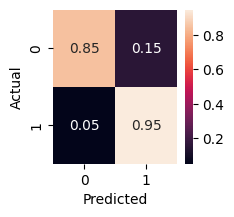

                     0             1  accuracy     macro avg  weighted avg
precision     0.901255      0.914962  0.910245      0.908108      0.909946
recall        0.847570      0.946413  0.910245      0.896991      0.910245
f1-score      0.873588      0.930422  0.910245      0.902005      0.909626
support    7118.000000  12335.000000  0.910245  19453.000000  19453.000000


In [158]:
accuracy(clf,all_data_x,all_data_y)

#### Conclusion
Since a relatively big improvement in accuracy is noticed,the final model will use combined data.

## 6. Hyperparameter Tuning

Finally, hyperparameter tuning is tested. Note: `GridSearchCV` being resource intensive, the `search_space` below is non-exhaustive. A small optimization of lowering the cross validation to 5 was made.

In [163]:
all_data_x.shape

(129685, 127)

In [180]:
t_clf=DecisionTreeClassifier()
search_space={
    'max_depth':[None,131],
    'min_samples_split':[2,10],
    'criterion':['gini','entropy','log_loss']
}
gscv=GridSearchCV(estimator=t_clf,param_grid=search_space,verbose=0,cv=5)

As mentioned before, the above grid search is non-exhaustive. However, this process conveys that the optimial `criterion`, `max_depth` and `min_samples_split` is higher than the default values. Although the globally optimal hyperparameters might not be in the `search_space`, the search helps validate whether or not the default max_depth and min_samples_split are decent values.

In [181]:
gscv.fit(all_data_x,all_data_y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 131],
                         'min_samples_split': [2, 10]})

In [182]:
gscv.best_params_

{'criterion': 'log_loss', 'max_depth': 131, 'min_samples_split': 2}

The new (locally) optimal parameters are `criterion`: log_loss and the `max_depth`: 131.

Decision Tree with `log_loss` criterion and max_depth=`131` is tested for accuracy

10 Fold CV score: 
0.9124345447162977


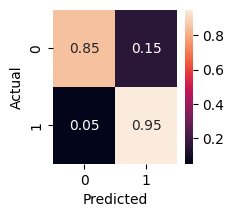

                     0             1  accuracy     macro avg  weighted avg
precision     0.904505      0.915832  0.911942      0.910168      0.911687
recall        0.848974      0.948277  0.911942      0.898626      0.911942
f1-score      0.875861      0.931772  0.911942      0.903816      0.911314
support    7118.000000  12335.000000  0.911942  19453.000000  19453.000000


In [184]:
clf=DecisionTreeClassifier(criterion='log_loss',max_depth=131)
accuracy(clf,all_data_x,all_data_y)

#### Conclusion
Since the performance of the tuned model is better than the previous results, the final model will utilize the newly found hyperparameters.

# Building and evaluating our final model

The following optimizations helped improve accuracy:
- Joining Feature mean and variance data and Bag of words data
- Eliminating the low importance features
- Using optimal criterion


The following optimizations worsened model accuracy (and thus, will not be used):
- Over- and Under- sampling
- Scaling Feature Mean and Variance columns

#### Final model

In [185]:
final_x=all_data_x
final_y=all_data_y

In [ ]:
best_model=DecisionTreeClassifier(criterion='log_loss',max_depth=131)

10 Fold CV score: 
0.9135834733126481


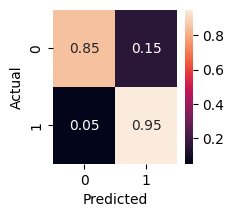

                     0             1  accuracy     macro avg  weighted avg
precision     0.903728      0.915297  0.911325      0.909512      0.911064
recall        0.847991      0.947872  0.911325      0.897931      0.911325
f1-score      0.874973      0.931300  0.911325      0.903136      0.910689
support    7118.000000  12335.000000  0.911325  19453.000000  19453.000000


In [195]:
accuracy(best_model,final_x,final_y)

##### Conclusion
The final model has an increase in accuracy by 2.2%. 

# What features does a commercial? Explaining the model

In this Prof.Golab-inspired section, the final model is given a closer look and explained.

For faster processing, a smaller subset of the data is used which should still suffice in giving good approximate explanantions.

In [196]:
small_final_x=final_x.sample(n=1000,random_state=42)
small_final_y=final_y.sample(n=1000,random_state=42)

In [197]:
best_model.fit(small_final_x,small_final_y)
explainer=shap.Explainer(best_model.predict,small_final_x)
sv=explainer(small_final_x)

Permutation explainer: 1001it [00:55, 14.61it/s]                          


In [ ]:
a=1 # Commercial example
b=2 # Non-commercial example


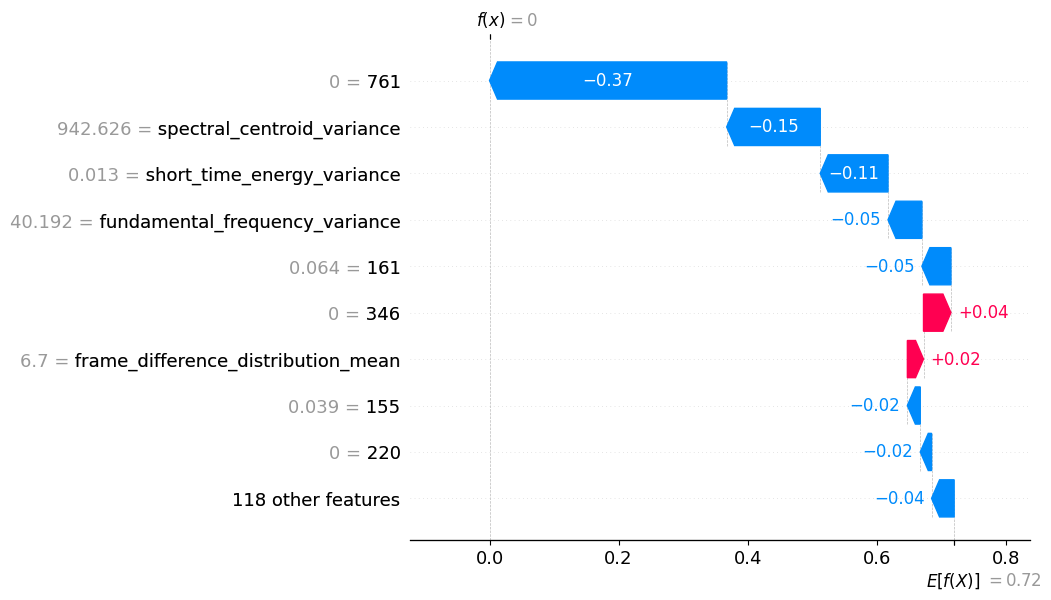

In [199]:
exp = shap.Explanation(
  sv.values, 
  sv.base_values[0], 
  sv.data, feature_names=list(small_final_x.columns)
)
shap.plots.waterfall(exp[a])

Notice E[f(x)] = 0.72, this is the null hypothesis. Since 72% of the data are about commercials, the model default probability is 0.72. It then use the features to steer the conclusion to one side or another.

The red-colored arrows signify that these features flag the data as being commercial.

The other features with more weight (blue-color) point are the most important mean and variance features (same as the one identified in section 4). The arbitrary numbers as columns correspond to the Bag Of Words columns. 


The value of one syllable or word (Column 761) from the Bag of Words being 0 makes it more likely that the broadcast is not a commercial. In simple terms, commercials tend to have this particular word/sound whereas non-commercials do not.

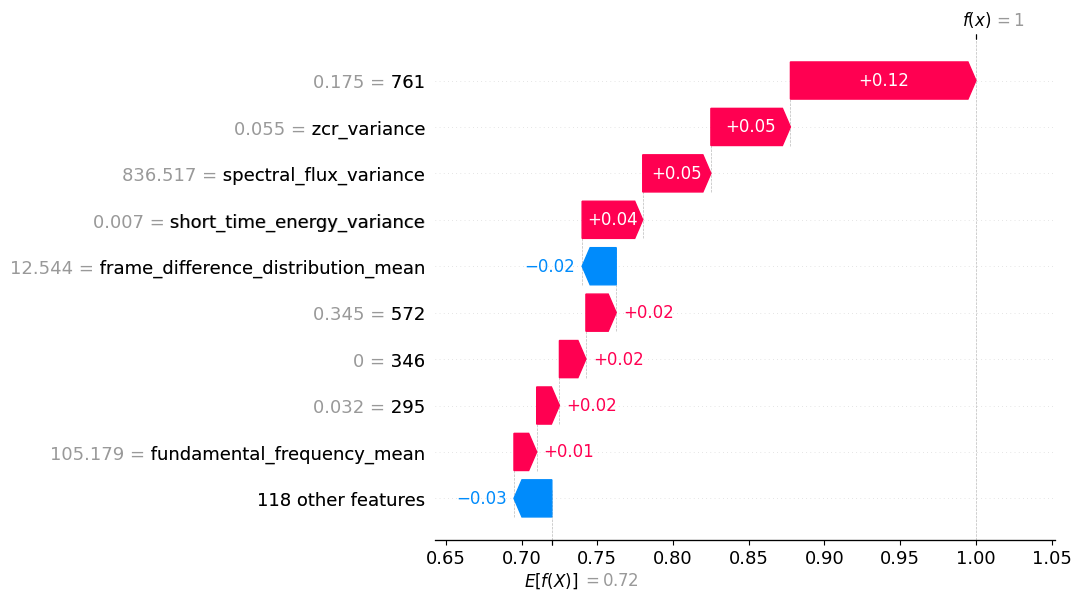

In [200]:
exp = shap.Explanation(
  sv.values, 
  sv.base_values[0], 
  sv.data, feature_names=list(small_final_x.columns)
)
shap.plots.waterfall(exp[b])

In this example, Column 761 is non-zero and points towards E[f(x)] = 1. Thus, the hypothesis from the first example is likely correct. This is unexpected as the column just represents a sound and it is non-intuitive that the presence of a single sound can be very important in determining whether a video is a commercial or not.

The zcr_variance also now appears as one of the top feature. Perhaps it has a very specific range for commercial, thus making a good feature when it is within a specific range (this explanation is made based on DecisionTrees work).

Since a decision tree classifier is used, asymetrical feature importance can be checked based on if the tree is symetrical or not.

#### Let's try to understand the model better by visualizing it

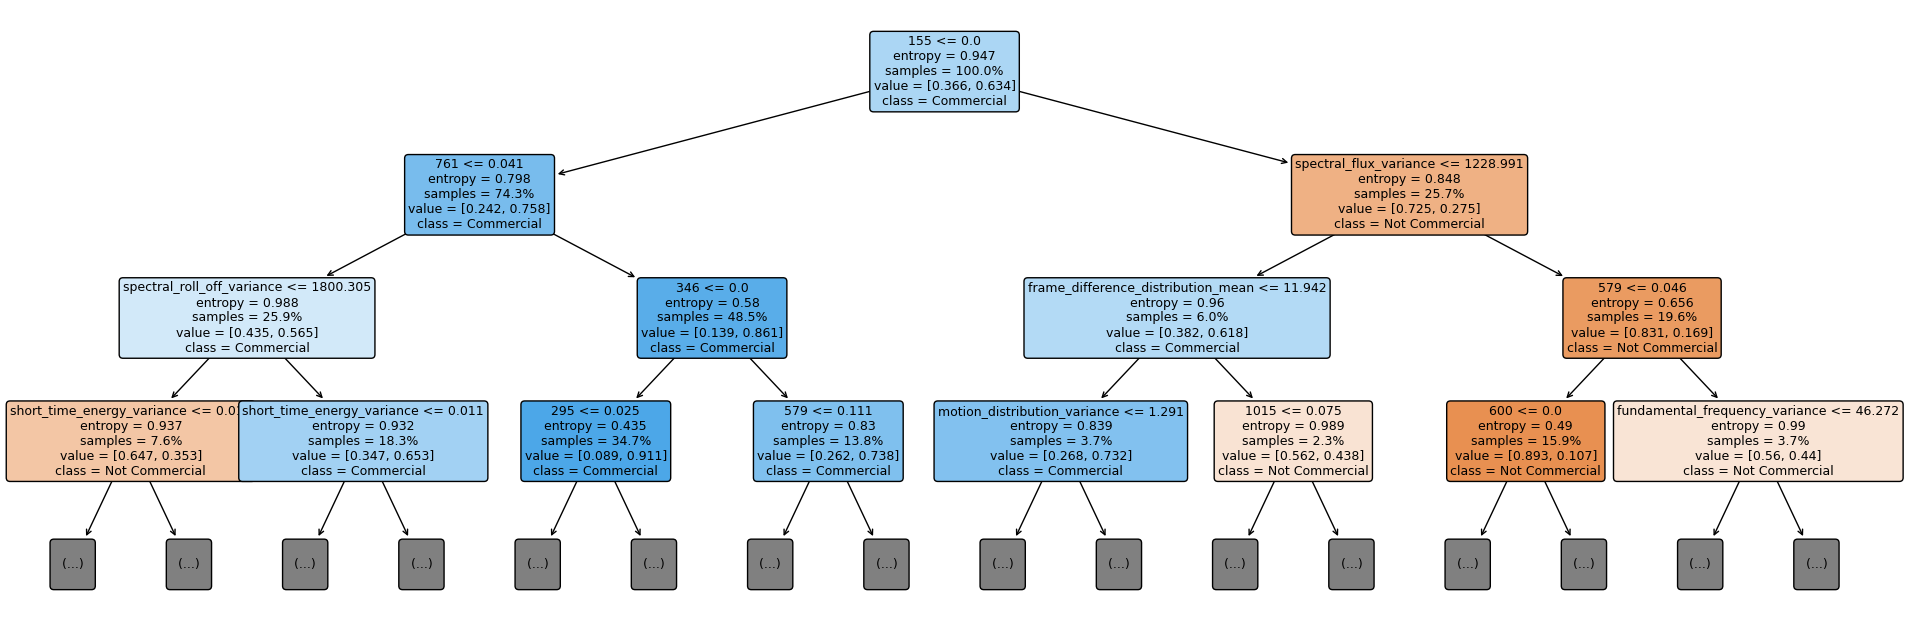

In [193]:
best_model.fit(final_x,final_y)
fig = plt.figure(figsize=(24, 8))
vis = tree.plot_tree(
  best_model, 
  feature_names = list(final_x.columns), 
  class_names = ['Not Commercial', 'Commercial'], 
  max_depth=3, 
  fontsize=9, 
  proportion=True, 
  filled=True, 
  rounded=True
)
fig.savefig("decision_tree.jpg")

As expected, the most important features are found at the top of the tree. The above image explains the final model well.

# Conclusion

The goal of our investigation of using a relatively simple model and optimizing on it through data processing and hyperparameter tuning is complete. With this, it is proven that visual and audio metadata alone can help classify if a broadcast is a commercial or not. 

A surprising discovery was the massive importance of the MFCC bag of audio words columns. This signifies that presence/non-presence of certain audio sounds are reliable predictors of whether a video segment is a commercial or not. 

To further elaborate, there are many applications where this type of model would be valuable. Computer vision tasks where audio and video are expensively processed can use such models to reduce CPU and memory usage and improve performance. This is done by analysing audio and video metadata with a simple model rather than an expensive computer vision model. 

This research has massive implications in the real world. Taking telephone voicemail spam classification as an example, instead of converting audio to speech and further to run classification, we can simply compute basic audio metadata that can be used to classify instead. This cuts down prediction time and resources needed to make the classification. In laymans terms, rather than decoding what is literally being said in the audio, we can tell if it is a spam voicemail by running our algorithm on physical characteristics of the audio (pitch differences and energy variance which are easy to compute).

It is important to note that the bag of words is actually an MFCC bag of audio words. MFCC (Mel-frequency cepstral coefficients) represents short-term power spectrum of a sound, relative to each other (similar to syllables). This was an important thing to learn in Machine Learning as it was not introduced in class and none of the team mates knew that Bag of Words have different types of representations. Manually computing the TF_IDF dataframe through transformations was great to learn as well especially given that it is a major concept in Natural Language Processing research.

For readers who want to continue with this research, there are a few further optimizations that can be tested:
- Using random forests: This model provided more accurate results but is computationally expensive and should be utilized where accuracy over training time is needed.
- Testing with simpler models for better performance and using other ways to account for data imbalance (data production using another ML model)
- Wider hyperparameter tuning: Wider search space in GridSearchCV is more likely to give us the globally optimal hyperparameters. 
- Eliminating less important bag of words features

# Bibliography

Digital Watermarking Alliance. (n.d.). Broadcast Monitoring. Retrieved February 13, 2023, from https://digitalwatermarkingalliance.org/digital-watermarking-applications/broadcast-monitoring/


Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Kotsiantis, S., Tsekouras, G., & Pintelas, P. E. (2005, January). Bagging Model Trees for Classification Problems. Researchgate. Retrieved February 14, 2023, from https://www.researchgate.net/publication/221565417_Bagging_Model_Trees_for_Classification_Problems 

scikit-learn. (n.d.). DecisionTreeClassifier - scikit-learn 0.24.2 documentation. Retrieved February 14, 2023, from https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html